In [51]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold, cross_val_score

In [52]:
import missingno as msno

In [53]:
#!pip install catboost

In [54]:
#!pip install missingno

In [55]:
import catboost as cb

In [56]:
import warnings
warnings.simplefilter("ignore")

In [57]:
df_bki = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/bki.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/train.csv')

print("df_bki.shape = {} rows, {} cols".format(*df_bki.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))
print("df_train.shape = {} rows, {} cols".format(*df_train.shape))

df_bki.shape = 945234 rows, 17 cols
df_test.shape = 165141 rows, 2 cols
df_train.shape = 110093 rows, 3 cols


In [58]:
# объединяем трейн и тест
data = pd.concat([df_train, df_test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [59]:
def clean_input(data) -> pd.DataFrame:
    """
    Перевод названий колонок в нижний регистр и вывод основной информации о наборе данных

    Parameters
    ----------
    data: Pandas DataFrame

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    #base_path = "data"
    #data = pd.read_csv(f"{base_path}/{data_path}")
    # Приводим все названия колонок к нижнему регистру
    data.columns = [col.lower() for col in data.columns]
    #print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    print(f"shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [67]:
df_train = clean_input(df_train)
df_test = clean_input(df_test)

shape = 110093 rows, 3 cols
shape = 165141 rows, 2 cols


In [60]:
df_bki = clean_input(df_bki)
data = clean_input(data)

shape = 945234 rows, 17 cols
shape = 275234 rows, 3 cols


In [62]:
data = data.merge(
    df_bki, how="left", on="application_number"
)

In [63]:
data.describe()

,application_number,target,bureau_id,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,days_credit_update,amt_annuity
count,7.936390e+05,317272.000000,7.293820e+05,729382.000000,729382.000000,684368.000000,460145.000000,2.521070e+05,729382.000000,7.293780e+05,6.199120e+05,4.779220e+05,7.293820e+05,729382.000000,2.081980e+05
mean,1.235771e+08,0.082172,5.974558e+06,1141.590745,0.772590,1818.294729,1016.966069,3.825436e+03,0.006250,3.536670e+05,1.358405e+05,6.310038e+03,3.668811e+01,593.781862,1.607272e+04
std,8.877318e+04,0.274628,5.328520e+05,794.907817,35.345512,4683.971360,715.756385,2.402188e+05,0.093939,1.051055e+06,6.423711e+05,4.483283e+04,4.855145e+03,726.260568,3.479859e+05
min,1.234233e+08,0.000000,5.001084e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000,0.000000e+00
25%,1.235001e+08,0.000000,5.513401e+06,474.000000,0.000000,382.000000,425.000000,0.000000e+00,0.000000,5.111100e+04,0.000000e+00,0.000000e+00,0.000000e+00,33.000000,0.000000e+00
50%,1.235770e+08,0.000000,5.977320e+06,986.000000,0.000000,861.000000,896.000000,0.000000e+00,0.000000,1.254870e+05,0.000000e+00,0.000000e+00,0.000000e+00,395.000000,0.000000e+00
75%,1.236541e+08,0.000000,6.435326e+06,1665.000000,0.000000,1504.000000,1487.000000,0.000000e+00,0.000000,3.150000e+05,3.944721e+04,0.000000e+00,0.000000e+00,908.000000,1.350000e+04
max,1.237309e+08,1.000000,6.942186e+06,2922.000000,2792.000000,42041.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,41934.000000,1.184534e+08


In [64]:
#Анализ пропусков

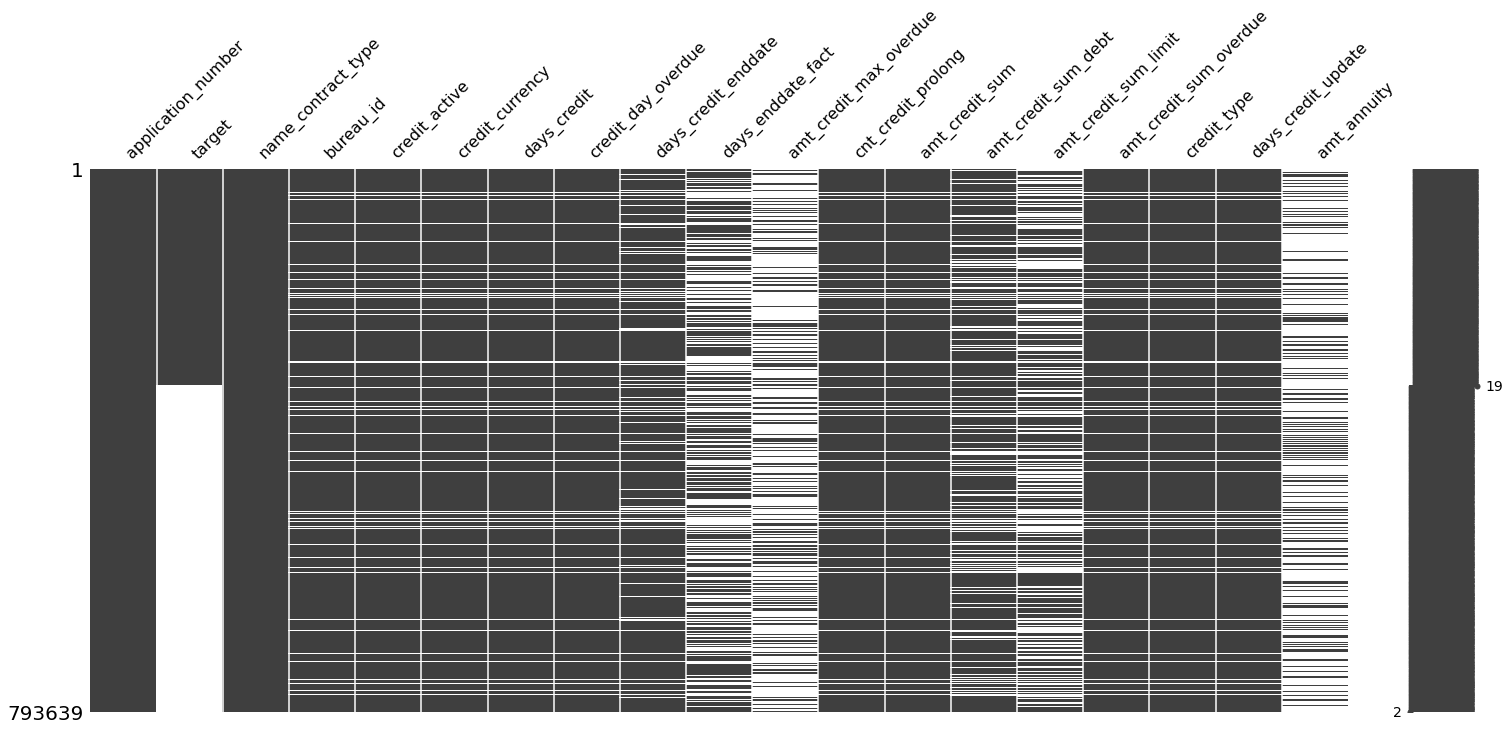

In [65]:
msno.matrix(data)

In [21]:
# выделяем по маске данные из трейна и из теста
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

# разделяем на трейн и тест
train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

In [49]:
train.shape

(317272, 17)

In [50]:
test.shape

(476367, 17)

## Числовые признаки

In [22]:
numerical_features = data.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 15


Index(['application_number', 'target', 'bureau_id', 'days_credit',
       'credit_day_overdue', 'days_credit_enddate', 'days_enddate_fact',
       'amt_credit_max_overdue', 'cnt_credit_prolong', 'amt_credit_sum',
       'amt_credit_sum_debt', 'amt_credit_sum_limit', 'amt_credit_sum_overdue',
       'days_credit_update', 'amt_annuity'],
      dtype='object')

In [23]:
numerical_features = numerical_features.drop(['application_number', 'target'], axis=1)

## Дискретные признаки

In [24]:
discrete_feature = [
    feature for feature in numerical_features
    if len(data[feature].unique())<25
]

In [25]:
discrete_feature

['cnt_credit_prolong']

In [29]:
def group_graf(group):
    fig, axes = plt.subplots(4, 4, figsize=(17, 12))

    for num, feature in enumerate(group):
        try:
            train_data, test_data = train[feature].copy(), test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        axes[num//4, num%4].set_title(feature, fontsize=14)

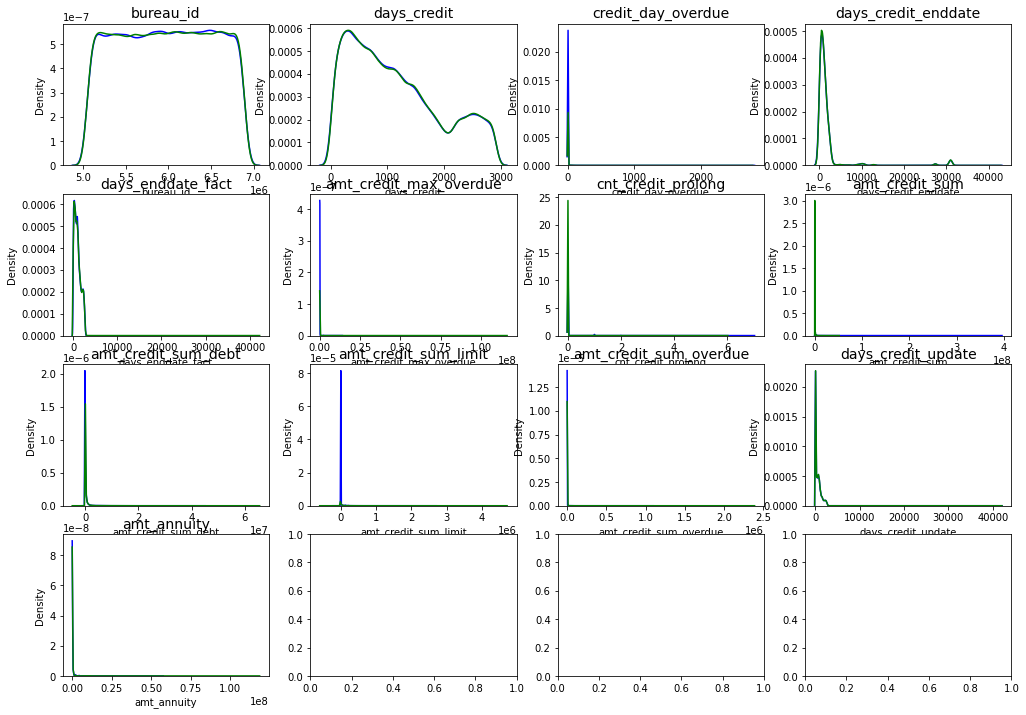

In [30]:
group = numerical_features
group_graf(group)

In [76]:
def feat_target_graf(group): 
    fig, axes = plt.subplots(4, 4, figsize=(17, 12))

    for num, feature in enumerate(group):
        target_0 = numerical_features.loc[numerical_features['target'] == 0, feature]
        target_1 = numerical_features.loc[numerical_features['target'] == 1, feature] 
                    
        sns.kdeplot(target_0, ax=axes[num//4, num%4], color="blue", label="0")
        sns.kdeplot(target_1, ax=axes[num//4, num%4], color="red", label="1")
            
        axes[num//4, num%4].set_title(feature, fontsize=14)

In [79]:
numerical_features = data.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 15


Index(['application_number', 'target', 'bureau_id', 'days_credit',
       'credit_day_overdue', 'days_credit_enddate', 'days_enddate_fact',
       'amt_credit_max_overdue', 'cnt_credit_prolong', 'amt_credit_sum',
       'amt_credit_sum_debt', 'amt_credit_sum_limit', 'amt_credit_sum_overdue',
       'days_credit_update', 'amt_annuity'],
      dtype='object')

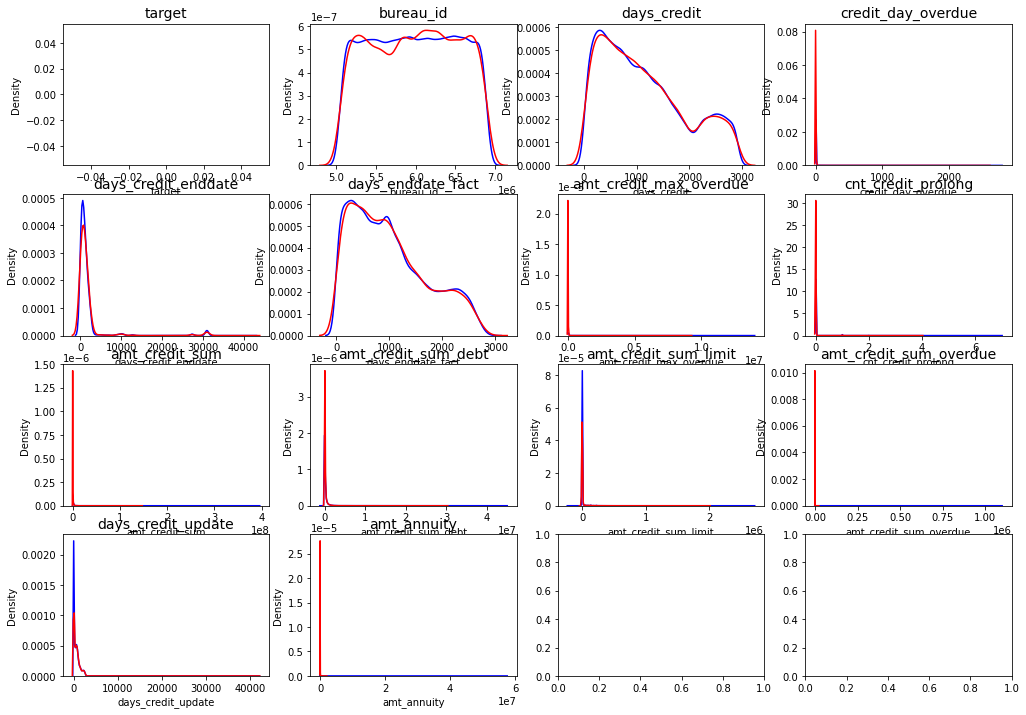

In [80]:
group = numerical_features.drop('application_number', axis=1)
feat_target_graf(group)

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)

CPU times: user 60 µs, sys: 0 ns, total: 60 µs
Wall time: 65.6 µs


In [107]:
numeric_features = numerical_features.drop(['target', 'application_number'], axis=1).columns.to_list()

In [106]:
numeric_features

['bureau_id',
 'days_credit',
 'credit_day_overdue',
 'days_credit_enddate',
 'days_enddate_fact',
 'amt_credit_max_overdue',
 'cnt_credit_prolong',
 'amt_credit_sum',
 'amt_credit_sum_debt',
 'amt_credit_sum_limit',
 'amt_credit_sum_overdue',
 'days_credit_update',
 'amt_annuity']

In [90]:
#сразу оценим нелинейную связь

In [108]:
forest.fit(train[numeric_features].fillna(-9999), train['target'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=2, oob_score=False,
                      random_state=27, verbose=0, warm_start=False)

Text(0.5, 1.0, 'What are the top important features to start with?')

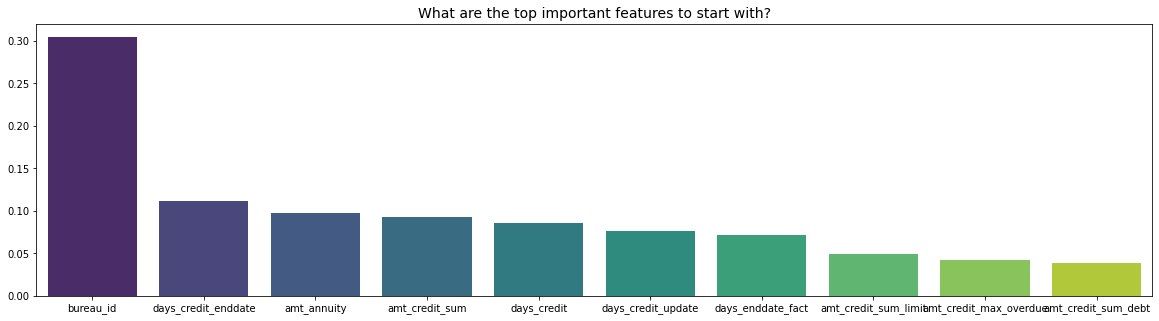

In [109]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train[numeric_features].columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [110]:
X_adv = pd.concat([
    train[numeric_features], test[numeric_features]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [111]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)
print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5025
CPU times: user 2min 58s, sys: 194 ms, total: 2min 58s
Wall time: 1min 31s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

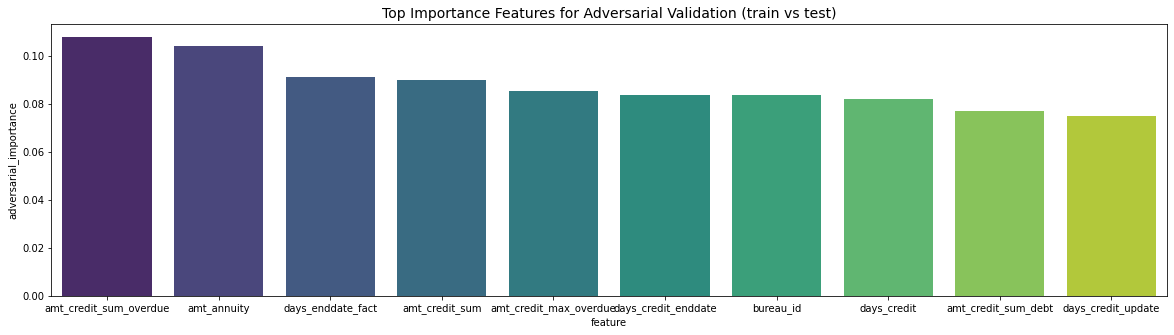

In [112]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)